# Model Training

In this section, we will try to train the dataset using several different algorithms and compare them to get the best model trained.

## Importing Libaries and Loading Dataset

In [36]:
import numpy as np
import pandas as pd
from dataclasses import dataclass

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from xgboost import XGBRegressor

In [2]:
# load the dataset
df = pd.read_csv('/home/er_bim/productivity-prediction/notebooks/data/worker_productivity_processed.csv')

## Prepare the Dataset for Modelling Process

### Separate the predictors and target

First, we separate the features in the dataset as predictors and target.

The target (y variable) feature is `actual_producticity`, thus the rest of the of the features after the feature `date` is eliminated are the predictors (X variables).

In [3]:
# set the X variables
X = df.drop(columns=['date', 'actual_productivity'],axis=1)

# set the y variable
y = df['actual_productivity']

# recheck the shape of each variable
print(f"The predictors consist of {X.shape[1]} columns and {X.shape[0]} rows.\n" )
print(f"The target column is {y.name} which consist of {y.shape[0]} rows." )

The predictors consist of 11 columns and 1108 rows.

The target column is actual_productivity which consist of 1108 rows.


In [4]:
# recheck the predictors
X.head(3)

,week,department,day,team,targeted_productivity,smv,wip,over_time,incentive,no_of_style_change,no_of_workers
0,Week1,sewing,Thursday,8,0.80,26.16,1108,7080,98,0,59
1,Week1,finishing,Thursday,1,0.75,3.94,802,960,0,0,8
2,Week1,sewing,Thursday,11,0.80,11.41,968,3660,50,0,31


In [5]:
# recheck the target column
y.head(3)

0    0.940725
1    0.886500
2    0.800570
Name: actual_productivity, dtype: float64

### Split the Dataset into Train and Test Sets

I will split the dataset into 70% train and 30% test.

In [6]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)

### Transform the predictors value

The categorical features need to be encoded to fit the model training; I chose the one-hot encoding method for this dataset.

For the numerical features, I want to do the experiment that both will be trained; the first one will be trained as the original value, and the second will be transformed first to make the value compacted. I choose the robust scaler transformation method.

In [7]:
# create instance for numerical and categorical features
num = X._get_numeric_data().columns
cat = X.drop(num, axis = 1).columns

In [8]:
# import libaries for column transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

std_scaler = StandardScaler()
rob_scaler = RobustScaler()
cat_encoder = OneHotEncoder()

# create column transformer pipeline for original value numerical features
preprocessor1 = ColumnTransformer([("OneHotEncoder", cat_encoder, cat), 
                                  ("passthrough", "passthrough", num)]
                                )

# create column transformer pipeline for standard scaled numerical features
preprocessor2 = ColumnTransformer([("OneHotEncoder", cat_encoder, cat), 
                                  ("StandardScaler", std_scaler, num)]
                                )

# create column transformer pipeline for robust scaled numerical features
preprocessor3 = ColumnTransformer([("OneHotEncoder", cat_encoder, cat), 
                                  ("RobustScaler", rob_scaler, num)]
                                )

In [9]:
# fit and transform X_train with original value in numerical features
X_train_ori = preprocessor1.fit_transform(X_train)

# transform X_test with original value in numerical features
X_test_ori = preprocessor1.transform(X_test)

# show the statistical summary
print(f"Basic statistical summary of predictors with original value: \n\n{pd.DataFrame(X_train_ori).loc[:, 13:20].describe()}")

Basic statistical summary of predictors with original value: 

               13          14          15           16            17  \
count  775.000000  775.000000  775.000000   775.000000    775.000000   
mean     6.597419    0.739097   14.724477   928.640000   4464.277419   
std      3.461564    0.076885   10.894635   270.193726   3228.813681   
min      1.000000    0.500000    2.900000     7.000000      0.000000   
25%      4.000000    0.700000    3.940000   814.000000   1440.000000   
50%      7.000000    0.750000   14.890000   841.000000   3960.000000   
75%     10.000000    0.800000   23.475000  1069.000000   6900.000000   
max     12.000000    0.800000   54.560000  1871.000000  15000.000000   

               18          19          20  
count  775.000000  775.000000  775.000000  
mean    23.873548    0.150968   33.388387  
std     27.862703    0.427324   22.065152  
min      0.000000    0.000000    2.000000  
25%      0.000000    0.000000    9.000000  
50%      0.000000    0.0

In [10]:
# fit and transform X_train with original value in numerical features
X_train_std_scaled = preprocessor2.fit_transform(X_train)

# transform X_test with original value in numerical features
X_test_std_scaled = preprocessor2.transform(X_test)

# show the statistical summary
print(f"Basic statistical summary of predictors with standard scaled value: \n\n{pd.DataFrame(X_train_std_scaled).loc[:, 13:20].describe()}")

Basic statistical summary of predictors with standard scaled value: 

                 13            14            15            16            17  \
count  7.750000e+02  7.750000e+02  7.750000e+02  7.750000e+02  7.750000e+02   
mean  -5.042561e-17  5.500976e-16 -2.131628e-16  6.417805e-17  8.136860e-17   
std    1.000646e+00  1.000646e+00  1.000646e+00  1.000646e+00  1.000646e+00   
min   -1.618065e+00 -3.111799e+00 -1.086050e+00 -3.413237e+00 -1.383530e+00   
25%   -7.508447e-01 -5.088371e-01 -9.905281e-01 -4.245622e-01 -9.372577e-01   
50%    1.163753e-01  1.419034e-01  1.520285e-02 -3.245693e-01 -1.562813e-01   
75%    9.835954e-01  7.926439e-01  8.037143e-01  5.198146e-01  7.548579e-01   
max    1.561742e+00  7.926439e-01  3.658796e+00  3.489972e+00  3.265139e+00   

                 18            19            20  
count  7.750000e+02  7.750000e+02  7.750000e+02  
mean  -1.948262e-17 -4.125732e-17 -1.100195e-16  
std    1.000646e+00  1.000646e+00  1.000646e+00  
min   -8.573815e-0

In [11]:
# fit and transform X_train with original value in numerical features
X_train_rob_scaled = preprocessor3.fit_transform(X_train)

# transform X_test with original value in numerical features
X_test_rob_scaled = preprocessor2.transform(X_test)

# show the statistical summary
print(f"Basic statistical summary of predictors with robust scaled value: \n\n{pd.DataFrame(X_train_rob_scaled).loc[:, 13:20].describe()}")

Basic statistical summary of predictors with robust scaled value: 

               13          14          15          16          17          18  \
count  775.000000  775.000000  775.000000  775.000000  775.000000  775.000000   
mean    -0.067097   -0.109032   -0.008473    0.343686    0.092359    0.477471   
std      0.576927    0.768852    0.557698    1.059583    0.591358    0.557254   
min     -1.000000   -2.500000   -0.613770   -3.270588   -0.725275    0.000000   
25%     -0.500000   -0.500000   -0.560532   -0.105882   -0.461538    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.500000    0.500000    0.439468    0.894118    0.538462    1.000000   
max      0.833333    0.500000    2.030714    4.039216    2.021978    2.260000   

               19          20  
count  775.000000  775.000000  
mean     0.150968   -0.012742  
std      0.427324    0.459691  
min      0.000000   -0.666667  
25%      0.000000   -0.520833  
50%      0

## Model Training

Now we try to do the modelling process of the dataset.

In [12]:
# create the function for model evaluation 
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

### Original Value Predictors

In [13]:
# create list of training algorithms
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=12),
    "Ridge": Ridge(random_state=23),
    "SVR": SVR(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=34),
    "Random Forest Regressor": RandomForestRegressor(random_state=45),
    "XGBRegressor": XGBRegressor(random_state=56),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=67)
}
model_list = []
r2_list =[]

# Define the train and test datasets
X_train=X_train_ori
X_test=X_test_ori

# display the model evaluation for each algorithm
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.1262
- Mean Absolute Error: 0.0902
- R2 Score: 0.3619
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1457
- Mean Absolute Error: 0.0998
- R2 Score: 0.3081


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.1541
- Mean Absolute Error: 0.1190
- R2 Score: 0.0475
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1727
- Mean Absolute Error: 0.1296
- R2 Score: 0.0284


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.1265
- Mean Absolute Error: 0.0912
- R2 Score: 0.3586
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1462
- Mean Absolute Error: 0.1005
- R2 Score: 0.3030


SVR
Model performance for Training set
- Root Mean Squared Error: 0.1542
- Mean Absolute Error: 0.1196
- R2 Score: 0.0462
----------------------------------
Model 

In [14]:
result_original_predictors = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
result_original_predictors

,Model Name,R2_Score
6,Random Forest Regressor,0.416958
7,XGBRegressor,0.378032
8,AdaBoost Regressor,0.362372
0,Linear Regression,0.308071
2,Ridge,0.303029
5,Decision Tree,0.179559
1,Lasso,0.028436
4,K-Neighbors Regressor,0.018704
3,SVR,-0.027336


### Standard Scaled Value Predictors

In [15]:
# create list of training algorithms
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=12),
    "Ridge": Ridge(random_state=23),
    "SVR": SVR(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=34),
    "Random Forest Regressor": RandomForestRegressor(random_state=45),
    "XGBRegressor": XGBRegressor(random_state=56),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=67)
}
model_list = []
r2_list =[]

# Define the train and test datasets
X_train=X_train_std_scaled
X_test=X_test_std_scaled

# display the model evaluation for each algorithm
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.1262
- Mean Absolute Error: 0.0902
- R2 Score: 0.3614
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1458
- Mean Absolute Error: 0.1001
- R2 Score: 0.3075


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.1579
- Mean Absolute Error: 0.1232
- R2 Score: 0.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1755
- Mean Absolute Error: 0.1333
- R2 Score: -0.0034


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.1262
- Mean Absolute Error: 0.0901
- R2 Score: 0.3619
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1456
- Mean Absolute Error: 0.0997
- R2 Score: 0.3088


SVR
Model performance for Training set
- Root Mean Squared Error: 0.1072
- Mean Absolute Error: 0.0802
- R2 Score: 0.5389
----------------------------------
Model

In [16]:
result_std_scaled_predictors = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
result_std_scaled_predictors

,Model Name,R2_Score
6,Random Forest Regressor,0.417082
7,XGBRegressor,0.378032
8,AdaBoost Regressor,0.371123
2,Ridge,0.308753
0,Linear Regression,0.307485
4,K-Neighbors Regressor,0.289706
3,SVR,0.269873
5,Decision Tree,0.179642
1,Lasso,-0.003373


### Robust Scaled Value Predictors

In [17]:
# create list of training algorithms
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=12),
    "Ridge": Ridge(random_state=23),
    "SVR": SVR(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=34),
    "Random Forest Regressor": RandomForestRegressor(random_state=45),
    "XGBRegressor": XGBRegressor(random_state=56),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=67)
}
model_list = []
r2_list =[]

# Define the train and test datasets
X_train=X_train_rob_scaled
X_test=X_test_rob_scaled

# display the model evaluation for each algorithm
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.1262
- Mean Absolute Error: 0.0903
- R2 Score: 0.3616
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1846
- Mean Absolute Error: 0.1438
- R2 Score: -0.1108


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.1579
- Mean Absolute Error: 0.1232
- R2 Score: 0.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1755
- Mean Absolute Error: 0.1333
- R2 Score: -0.0034


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.1262
- Mean Absolute Error: 0.0899
- R2 Score: 0.3617
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1801
- Mean Absolute Error: 0.1398
- R2 Score: -0.0569




SVR
Model performance for Training set
- Root Mean Squared Error: 0.1078
- Mean Absolute Error: 0.0812
- R2 Score: 0.5340
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1637
- Mean Absolute Error: 0.1297
- R2 Score: 0.1268


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1124
- Mean Absolute Error: 0.0749
- R2 Score: 0.4931
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1534
- Mean Absolute Error: 0.1017
- R2 Score: 0.2327


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2415
- Mean Absolute Error: 0.1631
- R2 Score: -0.8998


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0451
- Mean Absolute Error: 0.0277
- R2 Score: 0.9186
----------

In [18]:
result_rob_scaled_predictors = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
result_rob_scaled_predictors

,Model Name,R2_Score
4,K-Neighbors Regressor,0.232735
8,AdaBoost Regressor,0.175414
6,Random Forest Regressor,0.128368
3,SVR,0.126816
1,Lasso,-0.003373
2,Ridge,-0.056904
7,XGBRegressor,-0.088835
0,Linear Regression,-0.110838
5,Decision Tree,-0.899764


### Conclusion

The best r-squared value is resulted from the predictors that transformed using standard scaled method.

In [23]:
print(f"The best model is: \n\n{result_std_scaled_predictors.head(1)}")

The best model is: 

                Model Name  R2_Score
6  Random Forest Regressor  0.417082


## Random Forest Regression

In [24]:
rf_model = RandomForestRegressor(random_state=45)
rf_model = rf_model.fit(X_train_std_scaled, y_train)
y_pred = rf_model.predict(X_test_std_scaled)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 41.71


### Hyperparameter Tuning on Random Forest Regression Model

Let's try to improve the model accuracy value.

With the grid search and randomized search cross-validation methods on the Random Forest Regressor defined parameters grid.

In [25]:
# import the libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
model = RandomForestRegressor(random_state=45)


#### Grid Search Cross-Validation

In [26]:
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Define the train and test datasets
X_train=X_train_std_scaled
X_test=X_test_std_scaled

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the best model
r2_value_gridsearch = r2_score(y_test, y_test_pred)
print(f"Best Model Test Set R2: {r2_value_gridsearch:.4f}")

Best parameters found: {'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Model Test Set R2: 0.4151


#### Randomized Search Cross-Validation

In [27]:
# Set up the RandomizedSearchCV
rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter = 50, cv = 5, n_jobs = -1, scoring='r2', random_state=99)

# Define the train and test datasets
X_train=X_train_std_scaled
X_test=X_test_std_scaled

# Fit the GridSearchCV to the data
rand_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = rand_search.best_params_
best_model = rand_search.best_estimator_

print(f"Best parameters found: {best_params}")

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the best model
best_r2_randomizedsearch = r2_score(y_test, y_test_pred)
print(f"Best Model Test Set R2: {best_r2_randomizedsearch:.4f}")

Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'squared_error'}
Best Model Test Set R2: 0.4210


### Conclusion

The hyperparameter tuning experiments with randomized search cross-validation slightly improve the model performance, so we will apply its parameters to the model with the predictors transformed by standard scale method.

In [40]:
rf_model = RandomForestRegressor(n_estimators= 300, 
                                 min_samples_split= 5, 
                                 min_samples_leaf= 4, 
                                 max_depth= 20, 
                                 criterion= 'squared_error', 
                                 random_state=45
                                 )
rf_model = rf_model.fit(X_train_std_scaled, y_train)
y_pred = rf_model.predict(X_test_std_scaled)
score = r2_score(y_test, y_pred)*100
print(f"The acccuracy of the model is {score:.3f}%")

The acccuracy of the model is 42.099%


In [41]:
# check the parameters used by the model
from pprint import pprint
print('Parameters used by model:\n')
pprint(rf_model.get_params())

Parameters used by model:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}


In [34]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
343,0.850411,0.855127,-0.004717
615,0.840889,0.778856,0.062033
605,0.545658,0.613793,-0.068135
345,0.800437,0.784704,0.015733
476,0.259375,0.597991,-0.338616
...,...,...,...
717,0.891556,0.830172,0.061384
719,0.802243,0.713657,0.088587
305,0.600063,0.602476,-0.002414
639,0.272000,0.830835,-0.558835


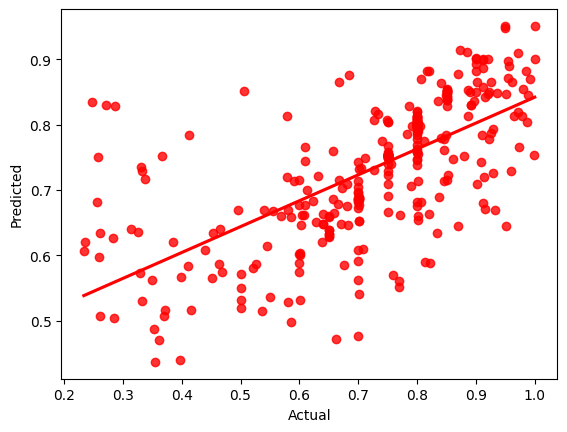

In [37]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');
plt.xlabel('Actual');
plt.ylabel('Predicted');